In [25]:
import datetime
from os import path
import math
import collections
import numpy as np
np.set_printoptions(formatter={'float_kind':"{:-.3e}".format})
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as signal
import core as co
import sys

In [2]:
import hist_data as hd

hd.set_hist_data(data_count=None)


Test data size (flats are duducted) is 677512
Test data start time is 2023:01:03 21:34
Test data end time is   2024:10:25 19:00
Subtracting moving avarage: True


forecast:
direction: buy-sell
min profit [PIP]: 7.51
panic value [PIP]: -0.50 - no panic



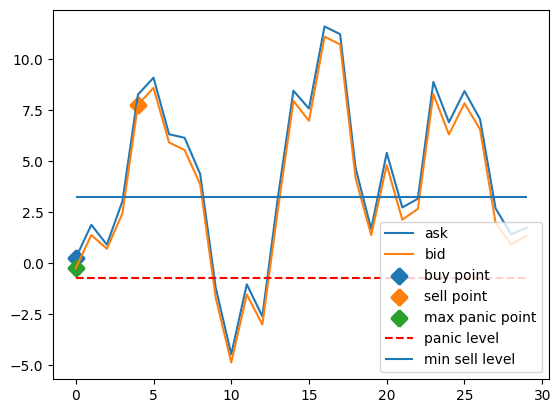

In [3]:
import importlib
import tokenizer as to
import forecast as fo
importlib.reload(fo)
import piecewise_fit as ls
importlib.reload(ls)
importlib.reload(co)

FORECAST_WINDOW = 30
FORECAST_THRESHOLD = 2e-4 + 1e-4 # spread

shift = 1000 # 1400 1500
forecast = fo.Forecast(
    hd.DATA[shift: FORECAST_WINDOW + shift], 
    threshold=FORECAST_THRESHOLD)
print(forecast)
forecast.plot(True)
# [0.000114, 0.000227, 0.000455, 0.00091, 0.00182, 0.00364, 0.00728, 0.0146]


In [74]:
FORECAST_THRESHOLD = co.config.FORECAST_THRESHOLD
PANIC_THRESHOLD = co.config.PANIC_THRESHOLD
FORECAST_WINDOW = co.config.FORECAST_WINDOW
RISK_FACTOR = 0.7

In [ ]:
dict_data = hd.ForexProvider()
oracle = fo.Oracle()

In [ ]:
def prices(data):
    # 
    timestamp, (timestamp, (ask, bid), volume)  = data
    # print((ask[0], bid[0]))
    return ask[0], bid[0]

def sell_buy(ask_price, bid_price, plot=False):
    """
    bid price == sell price
    ask price == buy price
    """
    sell_price = bid_price
    profit =  sell_price - ask_price

    bid_prices = [bid_price]
    ask_prices = [ask_price]
    profits = [profit]
    time = 0
    times = [time]

    max_profit = None
    def strategy(profit):
        nonlocal max_profit
        if max_profit is None:
            return False
        
        max_profit = max(max_profit, profit)
        return profit < max_profit * RISK_FACTOR


    while True: # buy (ask) low
        ask_price, bid_price = prices(next(dict_data))
        profit = sell_price - ask_price

        bid_prices.append(bid_price)
        ask_prices.append(ask_price)
        profits.append(profit)
        time += 1
        times.append(time)

        '''
        First step is to reach the predicted minimal profit level, but abort if
        the predictec panic level is passsed.
        '''
        if (profit >= FORECAST_THRESHOLD) and max_profit is None:
            max_profit = -sys.float_info.max
        if strategy(profit):
            break

    if plot:
        fig, bidask_pl = plt.subplots()
        # print(bid_prices)
        # print(ask_prices)
        bidask_pl.plot(times, bid_prices, color='blue', label='bid')
        bidask_pl.plot(times, ask_prices, color='red', label='ask')

        profit_pl = bidask_pl.twinx()
        profit_pl.hlines(FORECAST_THRESHOLD, times[0], 
                         times[-1], color='black', linestyle='--', label='min. profit')
        profit_pl.plot(times, profits, color='green', label='profit')
        
        bidask_pl.set_ylabel('bid, ask', color='black')
        profit_pl.set_ylabel('profit, min. profit, panic', color='green')

        bidask_pl.legend()
        profit_pl.legend()
        plt.show()

    return profit

def buy_sell(ask_price, bid_price, plot=False):
    buy_price = ask_price
    sell_price = bid_price
    profit = buy_price - sell_price
    while True:
        break



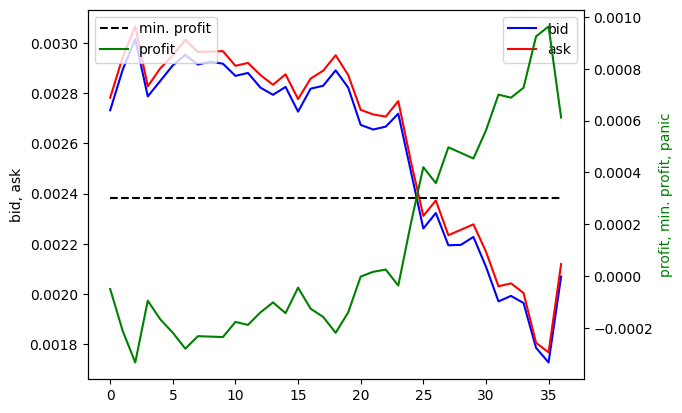

profit: 6.1


In [85]:
while True:
    timestamp_data = next(dict_data)
    if timestamp_data[0] not in oracle.predictions():
        continue
    
    ask_price, bid_price = prices(timestamp_data)
    advice, trans_time, panic, max_panic_time = oracle.prediction(timestamp_data[0])
    plot = True
    if advice == fo.Forecast.advices[fo.Forecast.IS_ASK]:
        print(f'profit: {sell_buy(ask_price, bid_price, plot=plot) / fo.Forecast.PIP:.1f}')
        break
    elif advice == fo.Forecast.advices[fo.Forecast.IS_BID]:
        buy_sell(ask_price, bid_price, plot=plot)
    else:
        pass


## GumblerSimple

In [190]:
_ = importlib.reload(hd)
_ = importlib.reload(fo)
_ = importlib.reload(gs) 

In [191]:
hd.set_hist_data(data_count=None)
forex_prov = hd.ForexProvider()
oracle = fo.Oracle(hd.ForexProvider())

advice: buy-sell, profit: 4.6e-04, min. profit: 3.0e-04


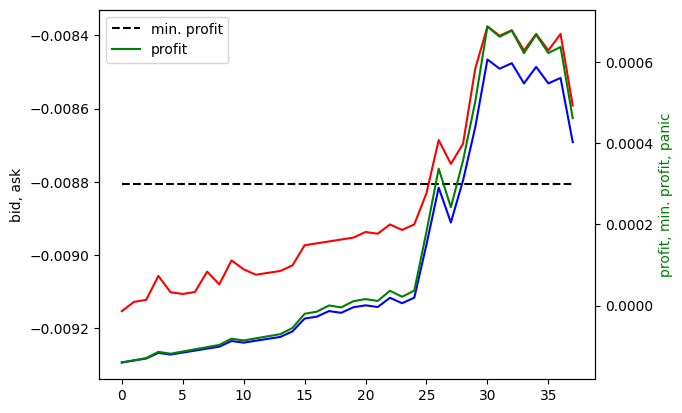

advice: buy-sell, profit: 4.6e-04, min. profit: 3.0e-04


In [ ]:
g = gs.gambler(forex_prediction=oracle.prediction, plot=True)

In [130]:
forex = hd.ForexProvider()
oracle = fo.Oracle()

In [167]:
prediction, prices = oracle.prediction(forex)
print(prediction)
print(prices)

('sell-buy', 8, -1.000000000007653e-05, 0)
(1672783800.0, (1672783800.0, ([-0.008396392361113447, -0.008346392361113342, -0.00848639236111337, -0.00844639236111333], [-0.00848639236111337, -0.008456392361113396, -0.008596392361113425, -0.008576392361113516]), 449130.0049))


In [115]:
def gambler(min_profit=3*gs.PIP, risk_factor=0.7):
    while True:
        timestamp_data = next(forex)
        if timestamp_data[0] not in oracle.predictions():
            continue
        
        ask_price, bid_price = prices(timestamp_data)
        advice, trans_time, panic, max_panic_time \
                                = oracle.prediction(timestamp_data[0])
        
        gumbler = gs.GumblerSimple(advice, forex, min_profit=min_profit, risk_factor=risk_factor)
        return gumbler.gumble(ask_price, bid_price)

def gamble_history(min_profit=3*gs.PIP, risk_factor=0.7):
    total = 0
    try:
        while True:
            total += gambler()
    except:
        print(f'tptal profit is: {total:.1e}')
        return total
    
total = gamble_history() 

tptal profit is: 0.0e+00
